<font size="+7">Desafio Data Science</font>

 - **Autor**: Saul Gonzalez
 - **Fecha** : 2023-10-29
 
 Una empresa de telecomunicaciones ha estudiado una pérdida de clientes, por
eso se acerca a nuestra empresa para construir un modelo para calcular la probabilidad de
abandono (churn) de los clientes y generar un ranking de clientes basado en esta
probabilidad. Sin embargo, necesitan que este sea rápido, por lo que se nos ha pedido
que no construyamos modelos basados en redes neuronales.

Se entrega el siguiente archivo data_users.csv en donde se encuentra el dataset con el
que construir la solución.

El objetivo del ejercicio es:
1. Construir un modelo para calcular la probabilidad de abandono (churn) de los
clientes y en base a estas, generar un ranking de los clientes
2. Además de las probabilidades, se requiere de un análisis de las métricas de
evaluación del modelo utilizadas
3. Describir paso a paso qué se está haciendo y por qué

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('default')

# Analisis Exploratorio Descriptivo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns

In [3]:
#matplotlib_inline.backend_inline.set_matplotlib_formats('png')
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('data/data_users.csv')

In [5]:
df.shape

(7043, 21)

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Nulos, duplicados y unicos

No hay datos Nan segun pandas, ya se verá si eso es del todo correcto:

In [7]:
df.isna().any(axis=1).sum()

0

No hay filas duplicadas:

In [8]:
df.duplicated().sum()

0

Se verifica que customerID  es unico en todo el dataset:

In [9]:
df['customerID'].unique().size ==  df.shape[0]

True

TotalCharges contiene celdas vacias:

In [10]:
df['TotalCharges'].value_counts()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

Tenemos 11 celdas vacias en dicho valor. Se verifica si este problema se encuentra en otras columnas:

In [11]:
df_temp = df.replace(r'^\s*$', np.nan, regex=True)
df_temp.isna().any(axis=1).sum()

11

Se obtiene el mismo valor por lo tento solo TotalCharges presenta el problema dentro de todo el dataset. Dado que son tan pocos datos, se procede a dropear las filas correspondientes:

In [12]:
df.drop(df[df['TotalCharges'] == ' ' ].index, inplace=True)

Ahora el nuevo tamaño del dataset es 11 filas mas pequeño:

In [13]:
df.shape

(7032, 21)

## Dtypes

### Dtypes originales

Se verifican los tipos generados por pandas:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

Con respecto a los dtypes se observa lo siguiente:
- TotalCharges debe ser de tipo float64.
- SeniorCitizen (int54) debe ser de tipo categorico.
- Salvo customerID, el resto de variables object pueden ser categoricas.

### Dtypes corregidos

In [15]:
# TotalCharges es float64
df = df.astype({'TotalCharges': 'float64'})

#lista de columnas tipo object a transformar
object_cols = df.select_dtypes(include='object').columns.to_list()

#solo customerID es de tipo object
object_cols.remove('customerID')

#SeniorCitizen tambien va a ser category
object_cols.append('SeniorCitizen')

#se transforman los objects que deben ser category
df = df.astype(dict.fromkeys(object_cols, 'category'))

Ahora los tipos estan OK:

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   tenure            7032 non-null   int64   
 6   PhoneService      7032 non-null   category
 7   MultipleLines     7032 non-null   category
 8   InternetService   7032 non-null   category
 9   OnlineSecurity    7032 non-null   category
 10  OnlineBackup      7032 non-null   category
 11  DeviceProtection  7032 non-null   category
 12  TechSupport       7032 non-null   category
 13  StreamingTV       7032 non-null   category
 14  StreamingMovies   7032 non-null   category
 15  Contract          7032 non-null   category
 16  PaperlessBilling  7032 non-nu

<font color='blue'>Ahora los tipos son los correctos y ademas el consumo de memoria se redujo a un tercio!</font>

## Graficos

No hay nada que graficar para customerID :(

### Countplot de variables categoricas

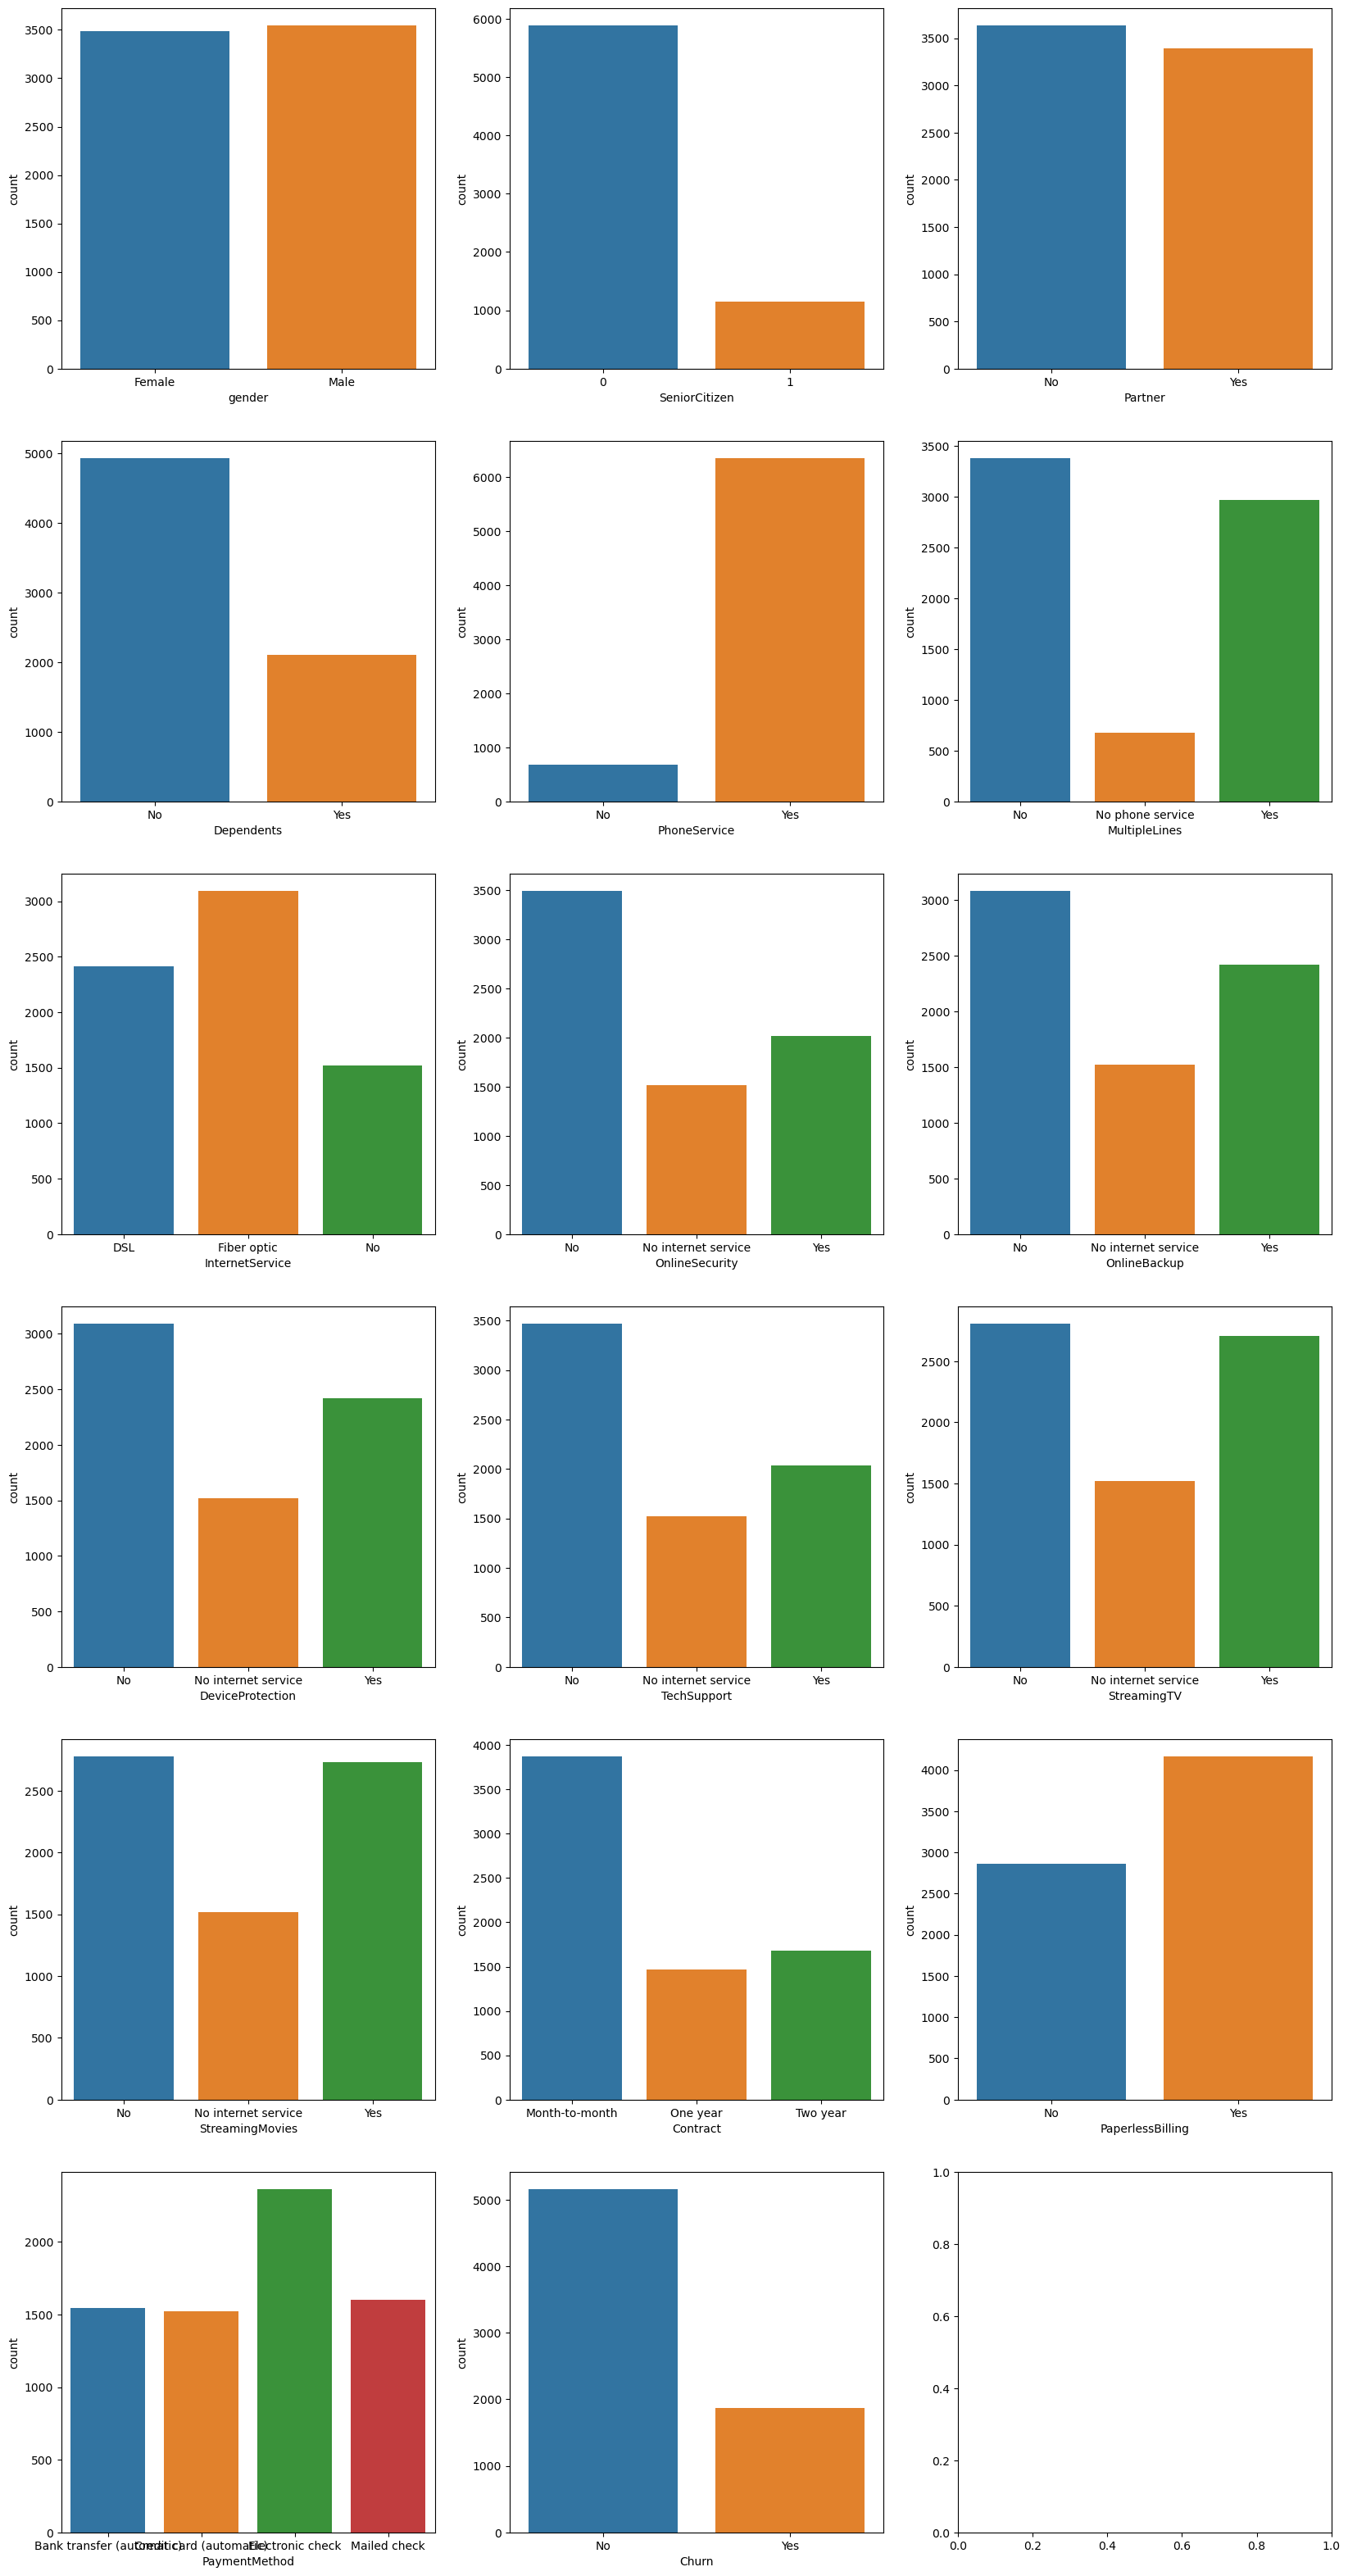

In [17]:
df_cat = df.select_dtypes(include='category')
df_cat_cols = df_cat.columns.to_list()

fig, axs = plt.subplots(6, 3, figsize=(20, 40))

for i, ax in enumerate(axs.flat):
    if i + 1 > len(df_cat_cols):
        continue
    sns.countplot(data=df_cat, x=df_cat_cols[i], ax=ax)

La variable objetivo Churn esta desbalanceada por lo que se va a considerar hacer uso de oversampling.

### Pairplot de variables numericas

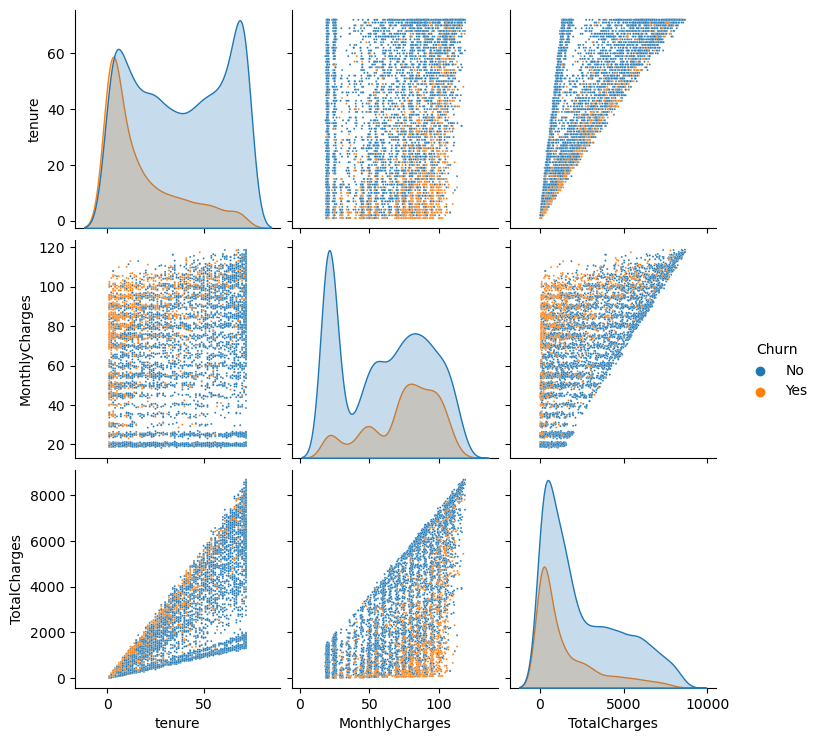

In [18]:
sns.pairplot(
    data = df,
    vars=df.select_dtypes(include='number').columns,
    hue='Churn',
    plot_kws={'s': 2}
);

### Mapa de calor de correlaciones de variables numericas

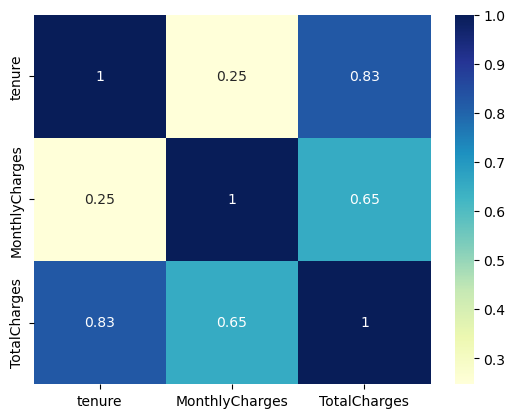

In [19]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='YlGnBu');

TotalCharges tiene una correlacion alta con tenure, quizas se pueden probar modelos eliminando una de ellas.

### Mapa de calor de correlacion de variables categoricas

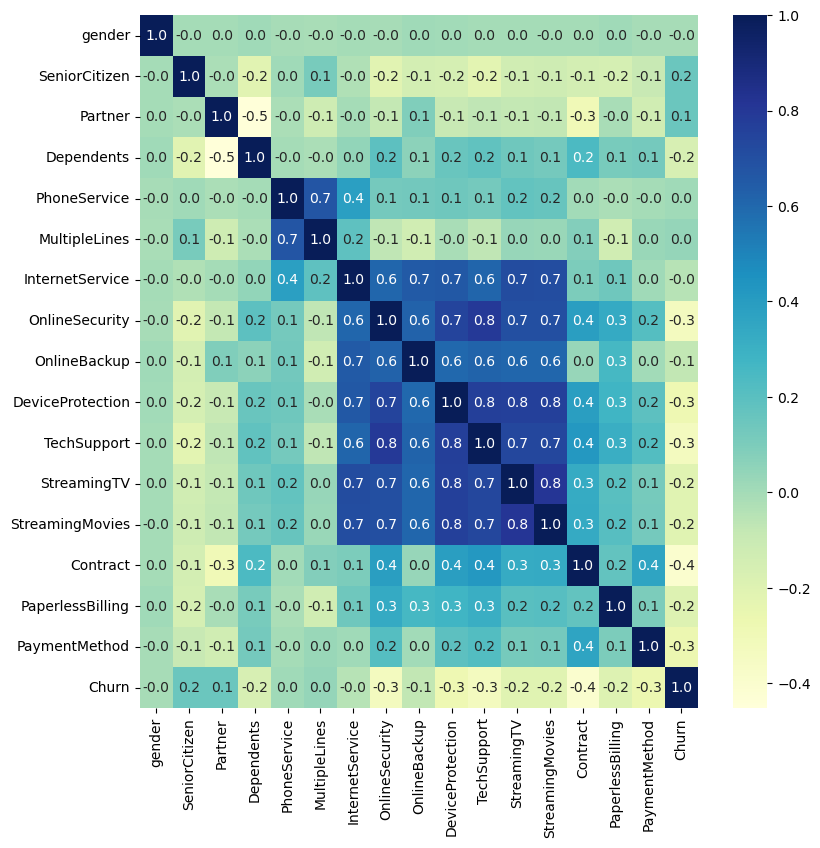

In [20]:
df_cat = df.select_dtypes(include='category')
df_cat_cols = df_cat.columns.to_list()

#factorizacion de categoricas
factorized_values = []

for col in df_cat_cols:
    factorized_values.append(df_cat[col].factorize()[0]) 
    
df_factorized = pd.DataFrame(factorized_values).T
df_factorized.columns = df_cat_cols

#grafico
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
sns.heatmap(df_factorized.corr(), annot=True, cbar=True, cmap='YlGnBu', fmt='.1f', ax=ax);

Hay varias columnas con una correlacion alta mayor a 0.8, quizas se pueden probar modelos eliminando una de ellas.

# Modelo

In [21]:
import pandas as pd
import numpy as np
from time import perf_counter_ns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import classification_report

## Importacion del dataset

Se importa de nuevo el dataset para que esta seccion sea totalmente independiente de la seccion anterior y considerando los hallazgos de dicha seccion:
- El custumerID va a ser el indice
- los tipos de variables correctos
- las celdas con espacios vacios se consideran Nan
- se eliminan las filas con datos nulos

In [22]:
types = {
    'customerID': 'object',
    'gender': 'category',
    'SeniorCitizen': 'category',
    'Partner': 'category',
    'Dependents': 'category',
    'tenure': 'int64',
    'PhoneService': 'category',
    'MultipleLines': 'category',
    'InternetService': 'category',
    'OnlineSecurity': 'category',
    'OnlineBackup': 'category',
    'DeviceProtection': 'category',
    'TechSupport': 'category',
    'StreamingTV': 'category',
    'StreamingMovies': 'category',
    'Contract': 'category',
    'PaperlessBilling': 'category',
    'PaymentMethod': 'category',
    'MonthlyCharges': 'float64',
    'TotalCharges': 'float64',
    'Churn': 'category'
}

df = pd.read_csv(
    "data/data_users.csv",
    index_col='customerID',
    skipinitialspace=True,
    dtype=types,
).dropna()

## Exploracion de modelos

In [23]:
RANDOM_STATE = 16478

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_include='number')),
        ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include='category'))
    ]
)

pipe = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('sample', ADASYN()),
           ('classifier', GradientBoostingClassifier())]
)
pipe_2 = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('sample', ADASYN()),
           ('classifier', SVC())]
)
pipe_3 = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('sample', ADASYN()),
           ('classifier', RandomForestClassifier())]
)
pipe_4 = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('sample', ADASYN()),
           ('classifier', DecisionTreeClassifier())]
)
pipe_5 = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('sample', ADASYN()),
           ('classifier', LogisticRegression())]
)

pipe_6 = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', LinearDiscriminantAnalysis()),]
)

param_grid = {
    'sample__random_state': [RANDOM_STATE],
    'classifier__random_state': [RANDOM_STATE],
    'classifier__max_depth': [12],
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [50, 100, 500, 1000, 2000],
    'classifier__subsample': [0.1, 0.5, 0.9]
}
param_grid_2 = {
    'sample__random_state': [RANDOM_STATE],
    'classifier__random_state': [RANDOM_STATE],
    'classifier__kernel': ['rbf'],
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}
param_grid_3 = {
    'sample__random_state': [RANDOM_STATE],
    'classifier__random_state': [RANDOM_STATE],
    'classifier__max_depth': [10,100,300,600],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__n_estimators': [10,100,300,600]
}
param_grid_4 = {
    'sample__random_state': [RANDOM_STATE],
    'classifier__random_state': [RANDOM_STATE],
    'classifier__max_depth': [10,100,300,600],
    'classifier__max_features': ['sqrt', 'log2']
}
param_grid_5 = {
    'sample__random_state': [RANDOM_STATE],
    'classifier__random_state': [RANDOM_STATE],
    'classifier__max_iter': [1000, 10000, 100000, 1000000, 10000000, 100000000],
    'classifier__C': np.logspace(-6, 6.0, num=13),
}
param_grid_6 = {
    'classifier__priors': [None, [0.5, 0.5], [0.4, 0.6], [0.05, 0.95]],
}

gs_1 = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
gs_2 = GridSearchCV(pipe_2, param_grid=param_grid_2, cv=5, n_jobs=-1, verbose=1)
gs_3 = GridSearchCV(pipe_3, param_grid=param_grid_3, cv=5, n_jobs=-1, verbose=1)
gs_4 = GridSearchCV(pipe_4, param_grid=param_grid_4, cv=5, n_jobs=-1, verbose=1)
gs_5 = GridSearchCV(pipe_5, param_grid=param_grid_5, cv=5, n_jobs=-1, verbose=1)
gs_6 = GridSearchCV(pipe_6, param_grid=param_grid_6, cv=5, n_jobs=-1, verbose=1)

print('\n1. GradientBoostingClassifier')
display(gs_1)
print('\n2. SVC')
display(gs_2)
print('\n3. RandomForestClassifier')
display(gs_3)
print('\n4. DecisionTreeClassifier')
display(gs_4)
print('\n5. LogisticRegresion')
display(gs_5)
print('\n5. LinearDiscriminantAnalysis')
display(gs_6)


1. GradientBoostingClassifier


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff6719bc90>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff64a4f950>)])),
                                       ('sample', ADASYN()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.5],
                         'classifier__max_depth': [12],
                         'classifier__n_estimators': [50, 100, 500, 1000, 2000],
                         'classifier__random_state': [16478],
                         'classifier__subsample': [0.1, 0.5, 0.9],
                         'sample__random_state': [16478]},
             verbose=1)


2. SVC


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff6719bc90>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff64a4f950>)])),
                                       ('sample', ADASYN()),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                           1000],
                         'classifier__gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1,
                                               1, 10],
                         'classifier__kernel': ['rbf'],
                         'classifier__random_state': [16478],
                         'sample__random_state': [16478]},
             verbose=1)


3. RandomForestClassifier


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff6719bc90>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff64a4f950>)])),
                                       ('sample', ADASYN()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 100, 300, 600],
                         'classifier__max_features': ['sqrt', 'log2', None],
                         'classifier__n_estimators': [10, 100, 300, 600],
                         'classifier__random_state': [16478],
                         'sample__random_state': [16478]},
             verbose=1)


4. DecisionTreeClassifier


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff6719bc90>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff64a4f950>)])),
                                       ('sample', ADASYN()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 100, 300, 600],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__random_state': [16478],
                         'sample__random_state': [16478]},
             verbose=1)


5. LogisticRegresion


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff6719bc90>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff64a4f950>)])),
                                       ('sample', ADASYN()),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                         'classifier__max_iter': [1000, 10000, 100000, 1000000,
                                                  10000000, 100000000],
                         'classifier__random_state': [16478],
                         'sample__random_state': [16478]},
             verbose=1)


5. LinearDiscriminantAnalysis


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff6719bc90>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0xffff64a4f950>)])),
                                       ('classifier',
                                        LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'classifier__priors': [None, [0.5, 0.5], [0.4, 0.6],
                                                [0.05, 0.95]]},
             verbose=1)

En algunas corridas previas se eliminaron columnas con alta correlacion entre si pero no otorgaron mejoras considerables en las metricas ni en el performance de los modelos por lo que se va mantener todas las variables:

In [24]:
#unwanted_cols = ['TechSupport','StreamingTV', 'StreamingMovies', 'tenure']
unwanted_cols = []

X= df.drop(columns=unwanted_cols + ['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=RANDOM_STATE)

In [25]:
def train(name, model, X_train, y_train):
    print(name)
    t0 = perf_counter_ns()
    model.fit(X_train, y_train)
    t1 = perf_counter_ns()
    print(f'done in {(t1 - t0) / 1e9:.1f}s')

In [26]:
train('GradientBoostingClassifier', gs_1, X_train, y_train)

GradientBoostingClassifier
Fitting 5 folds for each of 45 candidates, totalling 225 fits
done in 649.1s


In [27]:
train('SVC', gs_2, X_train, y_train)

SVC
Fitting 5 folds for each of 56 candidates, totalling 280 fits
done in 90.8s


In [28]:
train('RandomForestClassifier', gs_3, X_train, y_train)

RandomForestClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
done in 123.0s


In [29]:
train('DecisionTreeClassifier', gs_4, X_train, y_train)

DecisionTreeClassifier
Fitting 5 folds for each of 8 candidates, totalling 40 fits
done in 0.9s


In [30]:
train('LogisticRegression', gs_5, X_train, y_train)

LogisticRegression
Fitting 5 folds for each of 78 candidates, totalling 390 fits
done in 7.1s


In [31]:
train('LinearDiscriminantAnalysis', gs_6, X_train, y_train)

LinearDiscriminantAnalysis
Fitting 5 folds for each of 4 candidates, totalling 20 fits
done in 0.4s


In [32]:
print('\nGradientBoostingClassifier')
print(classification_report(y_test, gs_1.predict(X_test)))
print('\nSVC')
print(classification_report(y_test, gs_2.predict(X_test)))
print('\nRandomForestClassifier')
print(classification_report(y_test, gs_3.predict(X_test)))
print('\nDecisionTreeClassifier')
print(classification_report(y_test, gs_4.predict(X_test)))
print('\nLogisticRegression')
print(classification_report(y_test, gs_5.predict(X_test)))
print('n\LinearDiscriminantAnalysis')
print(classification_report(y_test, gs_6.predict(X_test)))


GradientBoostingClassifier
              precision    recall  f1-score   support

          No       0.85      0.85      0.85      1701
         Yes       0.59      0.60      0.59       620

    accuracy                           0.78      2321
   macro avg       0.72      0.72      0.72      2321
weighted avg       0.78      0.78      0.78      2321


SVC
              precision    recall  f1-score   support

          No       0.88      0.77      0.82      1701
         Yes       0.53      0.71      0.61       620

    accuracy                           0.75      2321
   macro avg       0.70      0.74      0.71      2321
weighted avg       0.79      0.75      0.76      2321


RandomForestClassifier
              precision    recall  f1-score   support

          No       0.85      0.85      0.85      1701
         Yes       0.59      0.59      0.59       620

    accuracy                           0.78      2321
   macro avg       0.72      0.72      0.72      2321
weighted avg     

El modelo seleccionado es LogisticRegression, la regresion logistica, considerando el alto recall para la clase 'yes'. Ademas es un modelo con excelente performance.

# Objetivos de la empresa

## Probabilidad de abandono

Ahora la parte mas divertida: la funcion que calcula la probalidad de churn de un cliente dado su customerID. Para ello se considera que el **ID pertenece al indice del dataframe**.

In [33]:
# la regresion logistica fue el modelo selecccionado
modelo = gs_5.best_estimator_

# el customerID debe ser parte index del df
def churn_proba(customer_id):
    x = (
        df
        .loc[customer_id]
        .to_frame()
        .T
        .drop(columns=['Churn'])
        )
    return modelo.predict_proba(x)[0][1]

Algunos ejemplos con el primer y ultimo cliente del dataset:

In [34]:
churn_proba('7590-VHVEG')

0.767132470580484

In [35]:
churn_proba('3186-AJIEK')

0.18555502642667224

## Ranking de clientes basados en la probabilidad de abandono

In [36]:
df['churn_proba'] = df.index.to_series().apply(churn_proba)

In [37]:
df.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_proba
customerID,,,,,,,,,,,,,,,,,,,,,
1597-FZREH,Female,0,No,No,2,Yes,No,DSL,No,No,Yes,Yes,Yes,Yes,Month-to-month,No,Electronic check,76.40,160.80,Yes,0.681907
1088-AUUZZ,Male,0,Yes,Yes,56,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,Yes,Credit card (automatic),75.85,4261.20,No,0.112480
2578-JQPHZ,Male,0,No,No,44,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),100.10,4378.35,No,0.265080


Dataset ordenado por probabilidad de abandono:

In [38]:
df.sort_values(by=['churn_proba'], ascending=False)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_proba
customerID,,,,,,,,,,,,,,,,,,,,,
5178-LMXOP,Male,1,Yes,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.10,95.10,Yes,0.914525
3049-SOLAY,Female,0,Yes,No,3,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.20,292.85,Yes,0.911263
4910-GMJOT,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.60,94.60,Yes,0.911021
8149-RSOUN,Female,0,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.85,93.85,Yes,0.910644
5567-WSELE,Male,1,Yes,No,3,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.60,279.55,Yes,0.910519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279-DYZQM,Male,0,Yes,Yes,71,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.45,1378.45,No,0.035525
2848-YXSMW,Male,0,Yes,Yes,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.40,1363.25,No,0.035483
3563-SVYLG,Male,0,Yes,Yes,68,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),62.65,4375.80,No,0.034543


### Etiquetas segun la probabilidad de abandono

Ahora generamos una clasificacion de clientes con tres etiquetas basadas en las probabilidades de abandono:
- baja: probabilidad inferior a 0.5
- media: probabilidad entre 0.5 y 0.8
- alta: probabilidad superior a 0.8

In [39]:
bins = [0.0, 0.5, 0.8, 1.0]
labels = ['baja', 'media', 'alta']
df['churn_proba_rank'] = pd.cut(df['churn_proba'], bins = bins ,labels = labels)

In [40]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_proba,churn_proba_rank
customerID,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.767132,media
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.190637,baja
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.562100,media
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.138901,baja
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.836157,alta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0.330648,baja
2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0.333786,baja
4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0.639883,media


### Countplot de clientes segun etiqueta churn_proba_rank

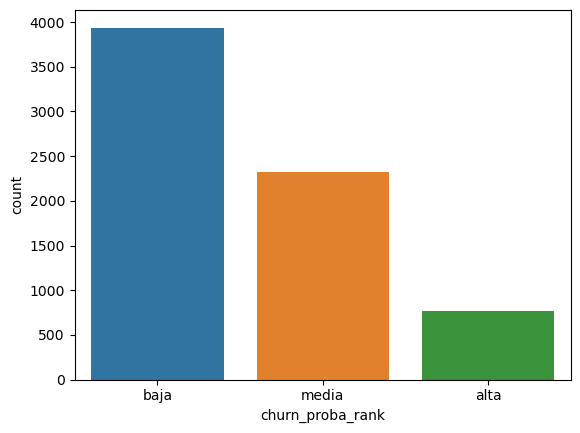

In [41]:
sns.countplot(data=df, x='churn_proba_rank');

# Preguntas de negocio

**P:** Le ha entregado los resultados del modelo a la empresa de telecomunicaciones. Ahora, debe explicar cómo esta información puede ser utilizada para una mejor toma de decisiones estratégicas.

**R:** Se pueden tomar acciones en base a los clientes con altas/media probabilidades de abandono: como promociones especiales para estas personas o mejoras en su servicio

**P:** ¿Cómo se podría complementar la solución para el cliente?

**R:**
- Desarrollar un programa que genere la probabilidad de churn al momento de ingresar la info
- Crear dashboards que muestren graficos relacionados con churn_proba_rank y churn_proba
- Determinar que variables son las mas influyentes (feature importance) y tomar acciones estrategicas para modificarlas

**P:** ¿Cómo se podría simplificar la tarea o hacerla más eficiente sin sacrificar la
calidad del modelo?

**R:** Eliminado columnas con alta correlacion entre si. Explorar mas modelos

**P:** ¿Cuáles son las limitaciones y riesgos de utilizar un modelo de predicción de
churn en un entorno empresarial? ¿Cuáles son las fuentes potenciales de sesgo
en los resultados?

**R:** Las metricas generados en el clasification report fueron en el mejor de los casos "buenas" para el recall de la clase 'yes' del churn (una de las metricas de mas interes). Siempre va a haber un error en la prediccion y se debe asumir con estrategias de negocio.

